In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import math
from collections import namedtuple
from torch import nn
import torch
import torchvision
from torchvision import transforms
import pandas as pd
import sys
import os
import neat
import multiprocessing
import random

KeyboardInterrupt: 

In [2]:
#creates x, y and range inputs 
#start is the -start to start range of the x, ys
#pixels is the number of pixels you want to for each row/colomn of the image
start=2
pixels=32
real=start-(start/(pixels))
x=np.linspace(-1*real,real,pixels)
x= x.repeat(pixels)
x=x.reshape((pixels,pixels))
x=np.stack((x,x.transpose()),axis=2)
r=np.sqrt(np.square(x).sum(axis=2))
x=np.append(x,np.expand_dims(r,2),axis=2)
x=np.append(x,np.ones((32,32,1)),axis=2)

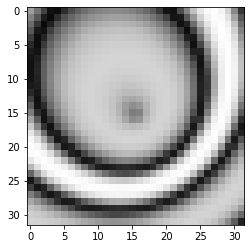

In [3]:
#place holder image for empty values in map elites
na=[[1,0,0,1,0,0,0,0],
   [1,1,0,1,0,0,0,0],
   [1,0,1,1,0,0,0,0],
   [1,0,0,1,0,0,0,0],
   [0,0,0,0,0,1,0,0],
   [0,0,0,0,1,0,1,0],
   [0,0,0,1,1,1,1,1],
   [0,0,0,1,0,0,0,1]]
#loads target images and coverts to proper form
im = PIL.Image.open("simple.png")
im1=im.convert("L").resize((pixels,pixels))
goal=(np.array(im1))
im.close()
plt.imshow(goal, cmap='Greys_r',vmin=0, vmax=255)

In [5]:
#definition of sigmoid function I don't think this is used anymore
def my_sigmoid(in_):
    return 1/(1 + np.exp(-in_))

In [6]:
#creates grandintes as to more closely math the orginal paper
def get_feature_sets(im):
    grad = np.gradient(im)
    feats=np.stack([im,grad[0],grad[1]])
    #for i in range(3):
        #mean = np.mean(feats[i])
        #std = np.std(feats[i])
        #feats[i]=(feats[i]-mean)/std
    return feats
goal_feats = get_feature_sets(goal)

In [7]:
#sum of sqaure diffenre fitness
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        myPic = np.empty((pixels,pixels))     
        for i in range(pixels*pixels):
            myPic[i%pixels][int(i/pixels)] = net.activate(x[i%pixels][int(i/pixels)])[0]
        myPic = np.clip(myPic, -1, 1)
        myPic=255*(1-np.abs(myPic))
        genome.pic = myPic
        genome.fitness = ((np.square(goal-myPic)).mean()-(255*255))/((-255*255))*100

In [22]:
#sum of sqaure diffenre fitness but for map elites
#genomes get appended to the archive so the auto encoder can retrain
#this was kinda a stop gap soultion that only holds the 5000 most recent members because i didnt what to mess with file sysems to store larger data sets
archive = []
archive_len = 0
def eval_genomes_me(genomes, config):
    global archive, archive_len
    temp_ar = []
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        myPic = np.empty((pixels,pixels))     
        for i in range(pixels*pixels):
            myPic[i%pixels][int(i/pixels)] = net.activate(x[i%pixels][int(i/pixels)])[0]
        myPic = np.clip(myPic, -1, 1)
        myPic=255*(1-np.abs(myPic))
        genome.pic = myPic
        genome.bc0 = sum(genome.size())
        temp_ar.append((genome_id,genome))
        genome.fitness = ((np.square(goal-myPic)).mean()-(255*255))/((-255*255))*100
    bc1s=test_encode(encoder, decoder, device, temp_ar, loss_fn)
    for i,genome in enumerate(temp_ar):
        genome[1].bc1 = bc1s[i]
    if archive_len < 3000:
        archive_len += len(temp_ar)
        archive.extend(temp_ar)
    else:
        for genome in temp_ar:
            archive[archive_len%len(archive)]
            archive_len += 1

In [9]:
#fitness matchin the orginal neat peper without gradients

def eval_genomes_other(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        myPic = np.empty((pixels,pixels))     
        for i in range(pixels*pixels):
            myPic[i%pixels][int(i/pixels)] = net.activate(x[i%pixels][int(i/pixels)])[0]
        myPic = np.clip(myPic, -1, 1)
        myPic=255*(1-np.abs(myPic))
        genome.pic = myPic
        fit = np.exp(np.abs(goal-myPic)*-3)
        fit=np.nan_to_num(fit)
        fit= 1-fit
        fit = np.mean(fit)
        genome.fitness = (1-np.square(fit))*100

In [10]:
#fitness matchin the orginal neat peper
def eval_genomes_new_fit(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        myPic = np.empty((32,32,1))     
        for i in range(32*32):
            myPic[i%32][int(i/32)] = net.activate(x[i%32][int(i/32)])
        myPic = np.squeeze(np.clip(myPic, -1, 1))
        myPic=255*(1-np.abs(myPic))
        my_feats = get_feature_sets(myPic)
        genome.pic = myPic
        fit = np.exp(np.abs(goal_feats-myPic)*-5)
        fit=np.nan_to_num(fit)
        fit= 1-fit
        fit = np.mean(fit)
        genome.fitness = (1-np.square(fit))*100

In [11]:
#number of pixels within a certian thershold of matching
#not changed to new standard
def eval_genomes_alt(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        myPic = np.empty((32,32,1))     
        for i in range(32*32):
            myPic[i%32][int(i/32)] = net.activate(x[i%32][int(i/32)])
        myPic = my_sigmoid(myPic)
        genome.pic = myPic
        genome.fitness = ((np.abs(goal-myPic)<.05).sum())/((32*32))*100

In [12]:
# extenstion of speciation from nea to enable map elites
class speciateElites(neat.DefaultSpeciesSet):
    
    def __init__(self, config, reporters):
        super().__init__(config, reporters)
        self.map_elites = {}
        self.max_loss=.01
        self.min_loss=.0
        self.first = True
        
    @classmethod
    def parse_config(cls, param_dict):
        return neat.config.DefaultClassConfig(param_dict,
                                  #default parameter used to set theseholf
                                  [neat.config.ConfigParameter('compatibility_threshold', float),
                                  #parameter used for map size
                                   neat.config.ConfigParameter('map_size', tuple, (32, 32)),
                                  #max of the complexoty for bc0 (nodes + connections)
                                   neat.config.ConfigParameter('complexity_range', int, 100),])

    def speciate(self, config, population, generation):
        """
        Place genomes into species by genetic similarity.
        Note that this method assumes the current representatives of the species are from the old
        generation, and that after speciation has been performed, the old representatives should be
        dropped and replaced with representatives from the new generation.  If you violate this
        assumption, you should make sure other necessary parts of the code are updated to reflect
        the new behavior.
        """
        assert isinstance(population, dict)

        compatibility_threshold = self.species_set_config.compatibility_threshold
        unspeciated = set(population)
        
        #fill map of elites
        self.fill_elites(population.items())
        
        # Find the best representatives for each existing species.
        unspeciated = set(population)
        distances = neat.species.GenomeDistanceCache(config.genome_config)
        new_representatives = {}
        new_members = {}
        for sid, s in self.species.items():
            candidates = []
            for gid in unspeciated:
                g = population[gid]
                d = distances(s.representative, g)
                candidates.append((d, g))

            # The new representative is the genome closest to the current representative.
            ignored_rdist, new_rep = min(candidates, key=lambda x: x[0])
            new_rid = new_rep.key
            new_representatives[sid] = new_rep
            new_members[sid] = [new_rid]
            unspeciated.remove(new_rid)

        # Partition population into species based on genetic similarity.
        while unspeciated:
            gid = unspeciated.pop()
            g = population[gid]

            # Find the species with the most similar representative.
            candidates = []
            for sid, rep in new_representatives.items():
                d = distances(rep, g)
                if d < compatibility_threshold:
                    candidates.append((d, sid))

            if candidates:
                ignored_sdist, sid = min(candidates, key=lambda x: x[0])
                new_members[sid].append(gid)
            else:
                # No species is similar enough, create a new species, using
                # this genome as its representative.
                sid = next(self.indexer)
                new_representatives[sid] = g
                new_members[sid] = [gid]
        
        
        # Partition elites into species based on genetic similarity.
        for gid, g in self.map_elites.values():

            # Find the species with the most similar representative.
            candidates = []
            for sid, rep in new_representatives.items():
                d = distances(rep, g)                
                candidates.append((d, sid))

            
            ignored_sdist, sid = min(candidates, key=lambda x: x[0])
            #easy change if you want elites to be able breed with other elites
            #new_members[sid].append(gid)
            g.sid = sid
            
            
                


        # Update species collection based on new speciation.
        self.genome_to_species = {}
        for sid, rep in new_representatives.items():
            s = self.species.get(sid)
            if s is None:
                s = neat.species.Species(sid, generation)
                self.species[sid] = s

            members = new_members[sid]
            for gid in members:
                self.genome_to_species[gid] = sid

            member_dict = dict((gid, population[gid]) for gid in members)
            s.update(rep, member_dict)

        gdmean = neat.math_util.mean(distances.distances.values())
        gdstdev = neat.math_util.stdev(distances.distances.values())
        self.reporters.info(
            'Mean genetic distance {0:.3f}, standard deviation {1:.3f}'.format(gdmean, gdstdev))
        cov = len(self.map_elites)*100/(self.species_set_config.map_size[0]*self.species_set_config.map_size[1])
        self.reporters.info(f"Archive_coverage = {cov:.3f}%")
        
    def fill_elites(self, to_fill):
        
        map_size = self.species_set_config.map_size
        bc_range = ((0,self.species_set_config.complexity_range),(self.min_loss, self.max_loss))
        for my_ind in to_fill:
            adjusted_bc0=math.ceil((my_ind[1].bc0-bc_range[0][0])/(bc_range[0][1]-bc_range[0][0])*map_size[0])-1
            adjusted_bc1=math.ceil((my_ind[1].bc1-bc_range[1][0])/(bc_range[1][1]-bc_range[1][0])*map_size[1])-1
            
            if adjusted_bc0>map_size[0]-1:
                adjusted_bc0 = map_size[0]-1
            elif adjusted_bc0<0:
                adjusted_bc0 =0
                
            if adjusted_bc1>map_size[1]-1:
                adjusted_bc1 = map_size[1]-1
            elif adjusted_bc1<0:
                adjusted_bc1 =0 
                
            key =adjusted_bc0*map_size[1] + adjusted_bc1
            if key in self.map_elites:
                if self.map_elites[key][1].fitness<my_ind[1].fitness:
                    my_ind[1].me_key=key
                    self.map_elites[key]=my_ind
            else:
                my_ind[1].me_key=key
                self.map_elites[key]=my_ind

In [13]:
class mapElites(neat.DefaultReproduction):
    
    def __init__(self, config, reporters, stagnation):
        super().__init__(config, reporters, stagnation)
    
    def reproduce(self, config, species, pop_size, generation):
        all_fitnesses = []
        remaining_species = []
        #does stagnation
        for stag_sid, stag_s, stagnant in self.stagnation.update(species, generation):
            if stagnant:
                self.reporters.species_stagnant(stag_sid, stag_s)
            else:
                all_fitnesses.extend(m.fitness for m in stag_s.members.values())
                remaining_species.append(stag_s)
        
        #cutsoff unfit species members
        if not remaining_species:
            species.species = {}
            return {}
        
        remaining_species_dict = {}
        species.species={}
        for s in remaining_species:
            old_members=list(s.members.items())
            repro_cutoff = int(math.ceil(self.reproduction_config.survival_threshold *
                                         len(old_members)))
            old_members = list(s.members.items())
            old_members.sort(reverse=True, key=lambda x: x[1].fitness)
            remaining_species_dict[s.key] = (old_members[:repro_cutoff],s)
            
            
        a_list=[*species.map_elites.values()]
        #this is currently hard set but should be set based on config popsize
        num_babies=150
        new_population ={}
        i=0
        #picks random elites and random member from species to procreate
        while i < num_babies:    
            parentA=random.choice(a_list)
            if parentA[1].sid in remaining_species_dict:
                gid = next(self.genome_indexer)
                child = config.genome_type(gid)
                b_pool, s = remaining_species_dict[parentA[1].sid]
                parentB=random.choice(b_pool)
                child.configure_crossover(parentA[1], parentB[1], config.genome_config)
                species.species[s.key]=s
                child.mutate(config.genome_config)
                new_population[gid] = child
                self.ancestors[gid] = (parentA[0], parentB[0])
                i+=1
            #if species went extinct remove elite
            else:
                map_elites.pop(parentA[1].me_key)
                a_list=[*species.map_elites.values()]
                
                
        return new_population

In [14]:
#all autoencoder stuff is from 
#https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac
#adam said used boilplate code for mnist data which this is but this time for python
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, stride=2, 
            padding=1, output_padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 4, stride=2, 
            padding=1, output_padding=0)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [15]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
encoder.float()
decoder.float()
def train_epoch_den(encoder, decoder, device, archive, loss_fn, optimizer,noise_factor=0.3):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch in archive: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_noisy = torch.from_numpy(image_batch[1].pic).squeeze().expand(1,1,-1,-1).float()
        image_noisy = image_noisy.to(device)    
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_noisy)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        train_loss.append(loss.detach().cpu().numpy())

    return np.min(train_loss), np.max(train_loss)

def test_encode(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        losses = np.empty(len(dataloader))
        for i, image_batch in enumerate(dataloader):
            # Move tensor to the proper device
            image_batch = torch.from_numpy(image_batch[1].pic).squeeze().expand(1,1,-1,-1).float()
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            losses[i]=loss_fn(decoded_data.cpu(), image_batch.cpu())
    return losses

Selected device: cpu


In [23]:
#BASIC NEAT
# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     'config-new')
#add cosine
def cos(x):
    return math.cos(x)

config.genome_config.activation_defs.add('cos', cos)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(False))

# Run until a solution is found.
winner = p.run(eval_genomes_other,10000)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
myPic = np.empty((pixels,pixels,1))      
for i in range(pixels*pixels): 
    myPic[i%pixels][int(i/pixels)] = winner_net.activate(x[i%pixels][int(i/pixels)])
myPic = np.clip(myPic, -1, 1)
myPic=255*(1-np.abs(myPic))
plt.imshow(myPic, cmap='Greys_r',vmin=0, vmax=255)


 ****** Running generation 0 ****** 

Population's average fitness: 0.25437 stdev: 0.29781
Best fitness: 1.25971 - size: (9, 33) - species 103 - id 103
Average adjusted fitness: 0.202
Mean genetic distance 3.939, standard deviation 0.305
Population of 300 members in 150 species
Total extinctions: 0
Generation time: 6.489 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.23937 stdev: 0.28477
Best fitness: 1.31676 - size: (9, 32) - species 141 - id 434
Average adjusted fitness: 0.182
Mean genetic distance 3.880, standard deviation 0.274
Population of 300 members in 154 species
Total extinctions: 0
Generation time: 11.365 sec (8.927 average)

 ****** Running generation 2 ****** 



KeyboardInterrupt: 

In [16]:
#redoes the defluat pop becuase normally speciation was called before evaluation 
#but because speciation is the step the map is filled i had to flip it 
class ME_Pop(neat.Population):
    def __init__(self, config, initial_state=None):
        self.reporters = neat.reporting.ReporterSet()
        self.config = config
        stagnation = config.stagnation_type(config.stagnation_config, self.reporters)
        self.reproduction = config.reproduction_type(config.reproduction_config,
                                                     self.reporters,
                                                     stagnation)
        if config.fitness_criterion == 'max':
            self.fitness_criterion = max
        elif config.fitness_criterion == 'min':
            self.fitness_criterion = min
        elif config.fitness_criterion == 'mean':
            self.fitness_criterion = neat.math_util.mean
        elif not config.no_fitness_termination:
            raise RuntimeError(
                "Unexpected fitness_criterion: {0!r}".format(config.fitness_criterion))

        if initial_state is None:
            # Create a population from scratch, then partition into species.
            self.population = self.reproduction.create_new(config.genome_type,
                                                           config.genome_config,
                                                           config.pop_size)
            self.species = config.species_set_type(config.species_set_config, self.reporters)
            self.generation = 0
        else:
            self.population, self.species, self.generation = initial_state

        self.best_genome = None

    def run(self, fitness_function, n=None):
        """
        Runs NEAT's genetic algorithm for at most n generations.  If n
        is None, run until solution is found or extinction occurs.
        The user-provided fitness_function must take only two arguments:
            1. The population as a list of (genome id, genome) tuples.
            2. The current configuration object.
        The return value of the fitness function is ignored, but it must assign
        a Python float to the `fitness` member of each genome.
        The fitness function is free to maintain external state, perform
        evaluations in parallel, etc.
        It is assumed that fitness_function does not modify the list of genomes,
        the genomes themselves (apart from updating the fitness member),
        or the configuration object.
        """

        if self.config.no_fitness_termination and (n is None):
            raise RuntimeError("Cannot have no generational limit with no fitness termination")

        k = 0
        while n is None or k < n:
            k += 1

            self.reporters.start_generation(self.generation)

            # Evaluate all genomes using the user-provided function.
            fitness_function(list(self.population.items()), self.config)
            
            # Divide the new population into species.
            self.species.speciate(self.config, self.population, self.generation)

            # Gather and report statistics.
            best = None
            for g in self.population.values():
                if g.fitness is None:
                    raise RuntimeError("Fitness not assigned to genome {}".format(g.key))

                if best is None or g.fitness > best.fitness:
                    best = g
            self.reporters.post_evaluate(self.config, self.population, self.species, best)

            # Track the best genome ever seen.
            if self.best_genome is None or best.fitness > self.best_genome.fitness:
                self.best_genome = best

            if not self.config.no_fitness_termination:
                # End if the fitness threshold is reached.
                fv = self.fitness_criterion(g.fitness for g in self.population.values())
                if fv >= self.config.fitness_threshold:
                    self.reporters.found_solution(self.config, self.generation, best)
                    break

            # Create the next generation from the current generation.
            self.population = self.reproduction.reproduce(self.config, self.species,
                                                          self.config.pop_size, self.generation)

            # Check for complete extinction.
            if not self.species.species:
                self.reporters.complete_extinction()

                # If requested by the user, create a completely new population,
                # otherwise raise an exception.
                if self.config.reset_on_extinction:
                    self.population = self.reproduction.create_new(self.config.genome_type,
                                                                   self.config.genome_config,
                                                                   self.config.pop_size)
                else:
                    raise CompleteExtinctionException()

            self.reporters.end_generation(self.config, self.population, self.species)

            self.generation += 1

        if self.config.no_fitness_termination:
            self.reporters.found_solution(self.config, self.generation, self.best_genome)

        return self.best_genome

In [ ]:
# MAP ELITES VERSION
# Load configuration.
archive = []
config = neat.Config(neat.DefaultGenome, mapElites,
                     speciateElites, neat.DefaultStagnation,
                     'config-me-spec')
#add cosine
def cos(x):
    return math.cos(x)

config.genome_config.activation_defs.add('cos', cos)

# Create the population, which is the top-level object for a NEAT run.
p = ME_Pop(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(False))

winner = p.run(eval_genomes_me,5)
for i in range(10):
# Run until a solution is found.
    max_loss = 0
    print('training autoencoder')
    for i in range(150):
        if i%15 == 0:
            print('.',end='')
        min_loss, max_loss = train_epoch_den(encoder, decoder, device, archive, loss_fn, optim)
    print('\nfinished autoencoder')
    p.species.max_loss=max_loss
    p.species.min_loss=min_loss
    old_elites=p.species.map_elites.values()
    p.species.map_elites = {}
    bc1s=test_encode(encoder, decoder, device, archive, loss_fn)
    for i,genome in enumerate(archive):
        genome[1].bc1 = bc1s[i]
    bc1s=test_encode(encoder, decoder, device, old_elites, loss_fn)
    for i,genome in enumerate(old_elites):
        genome[1].bc1 = bc1s[i]
    p.species.fill_elites(old_elites)
    p.species.fill_elites(archive)
    winner = p.run(eval_genomes_me,1000)
# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
myPic = np.empty((pixels,pixels,1))      
for i in range(pixels*pixels): 
    myPic[i%pixels][int(i/pixels)] = winner_net.activate(x[i%pixels][int(i/pixels)])
myPic = np.clip(myPic, -1, 1)
myPic=255*(1-np.abs(myPic))
plt.imshow(myPic, cmap='Greys_r',vmin=0, vmax=255)


 ****** Running generation 0 ****** 

Mean genetic distance 4.086, standard deviation 0.153
Archive_coverage = 0.098%
Population's average fitness: 75.73633 stdev: 6.24188
Best fitness: 87.31730 - size: (9, 33) - species 1 - id 9
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.226 sec

 ****** Running generation 1 ****** 

Mean genetic distance 2.969, standard deviation 1.119
Archive_coverage = 0.488%
Population's average fitness: 79.67777 stdev: 6.76888
Best fitness: 88.50968 - size: (8, 28) - species 1 - id 219
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.739 sec (5.483 average)

 ****** Running generation 2 ****** 

Mean genetic distance 2.362, standard deviation 0.380
Archive_coverage = 0.586%
Population's average fitness: 81.36106 stdev: 6.82975
Best fitness: 92.23233 - size: (9, 31) - species 1 - id 440
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.518 sec (5.494 average)

 ****** R

Mean genetic distance 2.548, standard deviation 0.668
Archive_coverage = 40.430%
Population's average fitness: 79.20369 stdev: 8.86785
Best fitness: 93.63991 - size: (11, 32) - species 1 - id 3706
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.551 sec (4.705 average)

 ****** Running generation 25 ****** 

Mean genetic distance 2.919, standard deviation 0.562
Archive_coverage = 41.309%
Population's average fitness: 79.76778 stdev: 7.94322
Best fitness: 93.60356 - size: (13, 32) - species 1 - id 3800
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.536 sec (4.662 average)

 ****** Running generation 26 ****** 

Mean genetic distance 3.189, standard deviation 0.509
Archive_coverage = 41.797%
Population's average fitness: 80.67013 stdev: 7.74752
Best fitness: 93.63052 - size: (9, 26) - species 1 - id 4041
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.622 sec (4.641 average)

 ****** Running gene

Mean genetic distance 3.423, standard deviation 0.575
Archive_coverage = 53.516%
Population's average fitness: 80.52852 stdev: 8.65221
Best fitness: 93.68683 - size: (15, 39) - species 1 - id 7393
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.644 sec (4.482 average)

 ****** Running generation 50 ****** 

Mean genetic distance 2.480, standard deviation 0.620
Archive_coverage = 53.711%
Population's average fitness: 78.51840 stdev: 9.63498
Best fitness: 93.60842 - size: (1, 1) - species 1 - id 7504
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.505 sec (4.481 average)

 ****** Running generation 51 ****** 

Mean genetic distance 3.100, standard deviation 0.686
Archive_coverage = 54.102%
Population's average fitness: 79.64363 stdev: 9.22828
Best fitness: 93.65922 - size: (9, 22) - species 1 - id 7665
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.418 sec (4.501 average)

 ****** Running genera

Mean genetic distance 2.203, standard deviation 0.378
Archive_coverage = 58.887%
Population's average fitness: 80.17854 stdev: 8.89965
Best fitness: 93.65219 - size: (16, 39) - species 1 - id 11250
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.356 sec (4.438 average)

 ****** Running generation 75 ****** 

Mean genetic distance 2.866, standard deviation 0.615
Archive_coverage = 59.082%
Population's average fitness: 79.56151 stdev: 8.65455
Best fitness: 93.96201 - size: (5, 13) - species 1 - id 11344
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.577 sec (4.472 average)

 ****** Running generation 76 ****** 

Mean genetic distance 2.324, standard deviation 0.510
Archive_coverage = 59.180%
Population's average fitness: 78.99140 stdev: 8.66552
Best fitness: 93.65215 - size: (6, 18) - species 1 - id 11492
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.650 sec (4.538 average)

 ****** Running ge

Mean genetic distance 3.081, standard deviation 0.685
Archive_coverage = 64.160%
Population's average fitness: 79.25061 stdev: 9.15285
Best fitness: 93.64092 - size: (3, 6) - species 1 - id 14859
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.829 sec (4.688 average)

 ****** Running generation 100 ****** 

Mean genetic distance 2.821, standard deviation 0.526
Archive_coverage = 64.453%
Population's average fitness: 78.39718 stdev: 9.08672
Best fitness: 93.64422 - size: (6, 15) - species 1 - id 15067
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.770 sec (4.703 average)

 ****** Running generation 101 ****** 

Mean genetic distance 2.279, standard deviation 0.445
Archive_coverage = 65.039%
Population's average fitness: 80.68583 stdev: 9.03433
Best fitness: 93.64837 - size: (6, 15) - species 1 - id 15190
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.731 sec (4.731 average)

 ****** Running ge

Mean genetic distance 2.321, standard deviation 0.555
Archive_coverage = 71.289%
Population's average fitness: 79.44405 stdev: 9.03709
Best fitness: 93.65496 - size: (4, 10) - species 1 - id 18710
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.580 sec (4.971 average)

 ****** Running generation 125 ****** 

Mean genetic distance 2.669, standard deviation 0.492
Archive_coverage = 71.582%
Population's average fitness: 79.47904 stdev: 8.83752
Best fitness: 93.63568 - size: (17, 44) - species 1 - id 18763
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.933 sec (4.959 average)

 ****** Running generation 126 ****** 

Mean genetic distance 2.269, standard deviation 0.512
Archive_coverage = 71.777%
Population's average fitness: 78.44831 stdev: 9.41232
Best fitness: 93.65566 - size: (1, 1) - species 1 - id 18947
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 4.849 sec (4.963 average)

 ****** Running g

Mean genetic distance 2.258, standard deviation 0.435
Archive_coverage = 74.902%
Population's average fitness: 78.77504 stdev: 8.37161
Best fitness: 93.64962 - size: (17, 41) - species 1 - id 22494
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.063 sec (5.187 average)

 ****** Running generation 150 ****** 

Mean genetic distance 2.181, standard deviation 0.349
Archive_coverage = 75.098%
Population's average fitness: 78.57033 stdev: 8.10049
Best fitness: 93.53929 - size: (22, 52) - species 1 - id 22572
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.402 sec (5.220 average)

 ****** Running generation 151 ****** 

Mean genetic distance 2.234, standard deviation 0.419
Archive_coverage = 75.293%
Population's average fitness: 79.05800 stdev: 9.40080
Best fitness: 93.61491 - size: (20, 48) - species 1 - id 22767
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.472 sec (5.223 average)

 ****** Runnin

Mean genetic distance 2.334, standard deviation 0.631
Archive_coverage = 76.855%
Population's average fitness: 80.43406 stdev: 9.05034
Best fitness: 93.63452 - size: (15, 36) - species 1 - id 25971
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.579 sec (5.436 average)

 ****** Running generation 174 ****** 

Mean genetic distance 2.320, standard deviation 0.371
Archive_coverage = 76.855%
Population's average fitness: 79.35554 stdev: 8.99530
Best fitness: 93.65581 - size: (11, 29) - species 1 - id 26183
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.702 sec (5.492 average)

 ****** Running generation 175 ****** 

Mean genetic distance 3.308, standard deviation 0.826
Archive_coverage = 77.051%
Population's average fitness: 79.45377 stdev: 9.33075
Best fitness: 93.65407 - size: (18, 41) - species 1 - id 26289
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.201 sec (5.498 average)

 ****** Runnin

Mean genetic distance 2.220, standard deviation 0.492
Archive_coverage = 78.320%
Population's average fitness: 80.53181 stdev: 8.53496
Best fitness: 93.65658 - size: (22, 51) - species 1 - id 29604
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.409 sec (5.403 average)

 ****** Running generation 198 ****** 

Mean genetic distance 2.961, standard deviation 0.661
Archive_coverage = 78.418%
Population's average fitness: 79.57674 stdev: 7.79741
Best fitness: 93.64784 - size: (9, 21) - species 1 - id 29839
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.165 sec (5.374 average)

 ****** Running generation 199 ****** 

Mean genetic distance 3.307, standard deviation 0.739
Archive_coverage = 78.516%
Population's average fitness: 80.00125 stdev: 8.69053
Best fitness: 93.65721 - size: (6, 12) - species 1 - id 29874
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.693 sec (5.453 average)

 ****** Running 

Mean genetic distance 2.190, standard deviation 0.370
Archive_coverage = 80.176%
Population's average fitness: 79.27436 stdev: 8.69852
Best fitness: 93.65584 - size: (22, 53) - species 1 - id 33228
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.866 sec (5.766 average)

 ****** Running generation 222 ****** 

Mean genetic distance 2.228, standard deviation 0.392
Archive_coverage = 80.273%
Population's average fitness: 79.20745 stdev: 9.26622
Best fitness: 93.65178 - size: (1, 1) - species 1 - id 33397
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.502 sec (5.803 average)

 ****** Running generation 223 ****** 

Mean genetic distance 3.290, standard deviation 0.727
Archive_coverage = 80.371%
Population's average fitness: 79.46771 stdev: 8.96234
Best fitness: 93.64623 - size: (4, 4) - species 1 - id 33535
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.235 sec (5.753 average)

 ****** Running ge

Mean genetic distance 2.296, standard deviation 0.583
Archive_coverage = 82.324%
Population's average fitness: 79.62862 stdev: 9.39867
Best fitness: 93.61451 - size: (12, 28) - species 1 - id 36923
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.685 sec (5.710 average)

 ****** Running generation 247 ****** 

Mean genetic distance 2.117, standard deviation 0.316
Archive_coverage = 82.520%
Population's average fitness: 80.44019 stdev: 8.99260
Best fitness: 93.64923 - size: (8, 18) - species 1 - id 37094
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.537 sec (5.724 average)

 ****** Running generation 248 ****** 

Mean genetic distance 2.088, standard deviation 0.272
Archive_coverage = 82.617%
Population's average fitness: 79.82531 stdev: 8.70493
Best fitness: 93.64996 - size: (20, 49) - species 1 - id 37318
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.786 sec (5.789 average)

 ****** Running

Mean genetic distance 2.288, standard deviation 0.475
Archive_coverage = 85.352%
Population's average fitness: 79.25864 stdev: 8.85150
Best fitness: 93.64911 - size: (15, 40) - species 1 - id 40570
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.410 sec (5.546 average)

 ****** Running generation 271 ****** 

Mean genetic distance 3.161, standard deviation 0.692
Archive_coverage = 85.352%
Population's average fitness: 80.04667 stdev: 9.16693
Best fitness: 93.65050 - size: (10, 27) - species 1 - id 40788
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.663 sec (5.580 average)

 ****** Running generation 272 ****** 

Mean genetic distance 2.216, standard deviation 0.533
Archive_coverage = 85.645%
Population's average fitness: 80.74888 stdev: 9.39060
Best fitness: 93.64927 - size: (1, 1) - species 1 - id 40848
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.093 sec (5.618 average)

 ****** Running 

Mean genetic distance 2.392, standard deviation 0.508
Archive_coverage = 87.012%
Population's average fitness: 79.39958 stdev: 8.84870
Best fitness: 93.65201 - size: (18, 45) - species 1 - id 44107
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.135 sec (5.774 average)

 ****** Running generation 295 ****** 

Mean genetic distance 2.521, standard deviation 0.437
Archive_coverage = 87.012%
Population's average fitness: 78.39752 stdev: 8.66639
Best fitness: 93.65354 - size: (3, 3) - species 1 - id 44308
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.227 sec (5.793 average)

 ****** Running generation 296 ****** 

Mean genetic distance 3.120, standard deviation 0.692
Archive_coverage = 87.305%
Population's average fitness: 79.80951 stdev: 8.83690
Best fitness: 93.61449 - size: (14, 38) - species 1 - id 44471
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.129 sec (5.828 average)

 ****** Running 

Mean genetic distance 3.259, standard deviation 0.562
Archive_coverage = 89.160%
Population's average fitness: 79.60036 stdev: 9.21763
Best fitness: 93.65328 - size: (15, 36) - species 1 - id 47721
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.189 sec (6.112 average)

 ****** Running generation 319 ****** 

Mean genetic distance 2.262, standard deviation 0.524
Archive_coverage = 89.160%
Population's average fitness: 78.99378 stdev: 9.12810
Best fitness: 93.65580 - size: (22, 54) - species 1 - id 47877
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.952 sec (6.094 average)

 ****** Running generation 320 ****** 

Mean genetic distance 2.059, standard deviation 0.210
Archive_coverage = 89.160%
Population's average fitness: 79.01765 stdev: 8.57315
Best fitness: 93.23631 - size: (11, 29) - species 1 - id 48029
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.750 sec (6.024 average)

 ****** Runnin

Mean genetic distance 2.158, standard deviation 0.404
Archive_coverage = 90.527%
Population's average fitness: 78.87476 stdev: 9.01745
Best fitness: 93.65550 - size: (14, 37) - species 1 - id 51350
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.037 sec (6.067 average)

 ****** Running generation 343 ****** 

Mean genetic distance 2.249, standard deviation 0.365
Archive_coverage = 90.625%
Population's average fitness: 79.07133 stdev: 8.99017
Best fitness: 93.65550 - size: (13, 31) - species 1 - id 51558
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.282 sec (6.048 average)

 ****** Running generation 344 ****** 

Mean genetic distance 3.412, standard deviation 0.803
Archive_coverage = 90.625%
Population's average fitness: 79.69400 stdev: 8.86155
Best fitness: 93.65477 - size: (16, 36) - species 1 - id 51697
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.330 sec (6.095 average)

 ****** Runnin

Mean genetic distance 2.209, standard deviation 0.394
Archive_coverage = 92.773%
Population's average fitness: 78.34904 stdev: 8.71092
Best fitness: 93.64597 - size: (11, 30) - species 1 - id 54926
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.612 sec (6.213 average)

 ****** Running generation 367 ****** 

Mean genetic distance 2.664, standard deviation 0.499
Archive_coverage = 92.773%
Population's average fitness: 79.20208 stdev: 9.40753
Best fitness: 93.65004 - size: (28, 60) - species 1 - id 55168
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.227 sec (6.266 average)

 ****** Running generation 368 ****** 

Mean genetic distance 3.222, standard deviation 0.715
Archive_coverage = 92.969%
Population's average fitness: 78.99863 stdev: 8.55794
Best fitness: 93.64026 - size: (13, 35) - species 1 - id 55268
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.181 sec (6.294 average)

 ****** Runnin

Mean genetic distance 3.306, standard deviation 0.719
Archive_coverage = 95.312%
Population's average fitness: 79.80837 stdev: 9.25094
Best fitness: 93.65445 - size: (16, 38) - species 1 - id 58630
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.680 sec (6.378 average)

 ****** Running generation 391 ****** 

Mean genetic distance 2.273, standard deviation 0.529
Archive_coverage = 95.312%
Population's average fitness: 78.72578 stdev: 8.83643
Best fitness: 93.68107 - size: (3, 5) - species 1 - id 58698
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.534 sec (6.409 average)

 ****** Running generation 392 ****** 

Mean genetic distance 2.947, standard deviation 0.585
Archive_coverage = 95.312%
Population's average fitness: 80.43418 stdev: 8.73920
Best fitness: 93.65361 - size: (2, 3) - species 1 - id 58921
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.553 sec (6.426 average)

 ****** Running ge

Mean genetic distance 2.156, standard deviation 0.343
Archive_coverage = 96.777%
Population's average fitness: 78.80449 stdev: 8.68161
Best fitness: 93.43367 - size: (13, 34) - species 1 - id 62159
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.381 sec (6.436 average)

 ****** Running generation 415 ****** 

Mean genetic distance 2.185, standard deviation 0.370
Archive_coverage = 96.973%
Population's average fitness: 79.73774 stdev: 8.56494
Best fitness: 93.65266 - size: (1, 1) - species 1 - id 62279
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.474 sec (6.419 average)

 ****** Running generation 416 ****** 

Mean genetic distance 2.767, standard deviation 0.503
Archive_coverage = 96.973%
Population's average fitness: 79.40610 stdev: 8.23719
Best fitness: 93.61722 - size: (24, 46) - species 1 - id 62467
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.650 sec (6.449 average)

 ****** Running 

Mean genetic distance 2.950, standard deviation 0.523
Archive_coverage = 98.438%
Population's average fitness: 79.22542 stdev: 8.16497
Best fitness: 93.65557 - size: (25, 50) - species 1 - id 65813
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.522 sec (6.572 average)

 ****** Running generation 439 ****** 

Mean genetic distance 2.438, standard deviation 0.598
Archive_coverage = 98.438%
Population's average fitness: 79.84567 stdev: 8.62536
Best fitness: 93.65528 - size: (16, 44) - species 1 - id 65890
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.623 sec (6.587 average)

 ****** Running generation 440 ****** 

Mean genetic distance 2.809, standard deviation 0.518
Archive_coverage = 98.438%
Population's average fitness: 78.64565 stdev: 8.84424
Best fitness: 93.61074 - size: (4, 11) - species 1 - id 66075
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.591 sec (6.592 average)

 ****** Running

Mean genetic distance 2.171, standard deviation 0.342
Archive_coverage = 99.121%
Population's average fitness: 81.17042 stdev: 9.14881
Best fitness: 93.65583 - size: (21, 52) - species 1 - id 69370
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.288 sec (6.317 average)

 ****** Running generation 463 ****** 

Mean genetic distance 2.782, standard deviation 0.509
Archive_coverage = 99.121%
Population's average fitness: 79.69786 stdev: 8.74523
Best fitness: 93.64960 - size: (2, 3) - species 1 - id 69465
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.566 sec (6.374 average)

 ****** Running generation 464 ****** 

Mean genetic distance 2.197, standard deviation 0.440
Archive_coverage = 99.121%
Population's average fitness: 79.73949 stdev: 8.92552
Best fitness: 93.65029 - size: (20, 44) - species 1 - id 69670
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.484 sec (6.425 average)

 ****** Running 

Mean genetic distance 2.133, standard deviation 0.278
Archive_coverage = 99.512%
Population's average fitness: 79.17958 stdev: 8.99769
Best fitness: 93.65407 - size: (27, 60) - species 1 - id 73093
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.356 sec (6.429 average)

 ****** Running generation 488 ****** 

Mean genetic distance 2.093, standard deviation 0.250
Archive_coverage = 99.512%
Population's average fitness: 78.87962 stdev: 9.24873
Best fitness: 93.65506 - size: (30, 66) - species 1 - id 73215
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.318 sec (6.413 average)

 ****** Running generation 489 ****** 

Mean genetic distance 2.349, standard deviation 0.371
Archive_coverage = 99.512%
Population's average fitness: 79.73875 stdev: 8.94527
Best fitness: 93.65407 - size: (4, 6) - species 1 - id 73443
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.001 sec (6.401 average)

 ****** Running 

Mean genetic distance 2.319, standard deviation 0.530
Archive_coverage = 99.902%
Population's average fitness: 79.87888 stdev: 8.45798
Best fitness: 93.65503 - size: (11, 25) - species 1 - id 76747
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.235 sec (6.625 average)

 ****** Running generation 512 ****** 

Mean genetic distance 2.332, standard deviation 0.367
Archive_coverage = 99.902%
Population's average fitness: 79.97724 stdev: 8.34633
Best fitness: 93.64724 - size: (5, 11) - species 1 - id 76809
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.456 sec (6.605 average)

 ****** Running generation 513 ****** 

Mean genetic distance 3.199, standard deviation 0.705
Archive_coverage = 99.902%
Population's average fitness: 77.81872 stdev: 8.06829
Best fitness: 93.61491 - size: (13, 31) - species 1 - id 77048
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.471 sec (6.633 average)

 ****** Running

Mean genetic distance 2.623, standard deviation 0.483
Archive_coverage = 99.902%
Population's average fitness: 79.05247 stdev: 8.54210
Best fitness: 93.65352 - size: (12, 32) - species 1 - id 80422
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.583 sec (6.490 average)

 ****** Running generation 537 ****** 

Mean genetic distance 3.245, standard deviation 0.746
Archive_coverage = 99.902%
Population's average fitness: 79.08619 stdev: 9.25015
Best fitness: 93.73050 - size: (13, 34) - species 1 - id 80650
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.212 sec (6.479 average)

 ****** Running generation 538 ****** 

Mean genetic distance 2.290, standard deviation 0.579
Archive_coverage = 99.902%
Population's average fitness: 79.11502 stdev: 8.72091
Best fitness: 93.65362 - size: (15, 31) - species 1 - id 80839
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.796 sec (6.500 average)

 ****** Runnin

Mean genetic distance 2.357, standard deviation 0.370
Archive_coverage = 99.902%
Population's average fitness: 78.53187 stdev: 9.15241
Best fitness: 93.65583 - size: (22, 51) - species 1 - id 84131
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.917 sec (6.365 average)

 ****** Running generation 561 ****** 

Mean genetic distance 2.094, standard deviation 0.291
Archive_coverage = 100.000%
Population's average fitness: 78.65844 stdev: 8.71872
Best fitness: 93.65583 - size: (21, 51) - species 1 - id 84191
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 7.035 sec (6.454 average)

 ****** Running generation 562 ****** 

Mean genetic distance 2.191, standard deviation 0.331
Archive_coverage = 100.000%
Population's average fitness: 79.37992 stdev: 8.91635
Best fitness: 93.64265 - size: (1, 1) - species 1 - id 84422
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.713 sec (6.541 average)

 ****** Runnin

Mean genetic distance 3.362, standard deviation 0.768
Archive_coverage = 100.000%
Population's average fitness: 80.00315 stdev: 8.99518
Best fitness: 93.65553 - size: (5, 12) - species 1 - id 87650
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.243 sec (6.456 average)

 ****** Running generation 585 ****** 

Mean genetic distance 3.354, standard deviation 0.782
Archive_coverage = 100.000%
Population's average fitness: 80.54371 stdev: 8.76651
Best fitness: 93.65703 - size: (16, 32) - species 1 - id 87781
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.566 sec (6.525 average)

 ****** Running generation 586 ****** 

Mean genetic distance 2.376, standard deviation 0.562
Archive_coverage = 100.000%
Population's average fitness: 80.12656 stdev: 8.64949
Best fitness: 93.64736 - size: (19, 42) - species 1 - id 87963
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.582 sec (6.556 average)

 ****** Runn

Mean genetic distance 2.048, standard deviation 0.229
Archive_coverage = 100.000%
Population's average fitness: 80.10443 stdev: 9.04231
Best fitness: 93.65635 - size: (12, 33) - species 1 - id 91259
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.776 sec (6.552 average)

 ****** Running generation 609 ****** 

Mean genetic distance 2.110, standard deviation 0.316
Archive_coverage = 100.000%
Population's average fitness: 78.58307 stdev: 8.56202
Best fitness: 93.65074 - size: (18, 40) - species 1 - id 91376
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.201 sec (6.543 average)

 ****** Running generation 610 ****** 

Mean genetic distance 2.151, standard deviation 0.301
Archive_coverage = 100.000%
Population's average fitness: 79.54711 stdev: 9.14449
Best fitness: 93.65573 - size: (29, 65) - species 1 - id 91617
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.727 sec (6.564 average)

 ****** Run

Mean genetic distance 2.901, standard deviation 0.550
Archive_coverage = 100.000%
Population's average fitness: 78.66710 stdev: 8.89875
Best fitness: 93.71121 - size: (4, 7) - species 1 - id 94885
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.633 sec (6.410 average)

 ****** Running generation 633 ****** 

Mean genetic distance 2.984, standard deviation 0.505
Archive_coverage = 100.000%
Population's average fitness: 78.24423 stdev: 8.01248
Best fitness: 93.65207 - size: (15, 33) - species 1 - id 95023
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.203 sec (6.426 average)

 ****** Running generation 634 ****** 

Mean genetic distance 3.466, standard deviation 0.796
Archive_coverage = 100.000%
Population's average fitness: 79.06105 stdev: 8.48903
Best fitness: 93.63580 - size: (10, 29) - species 1 - id 95242
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.750 sec (6.417 average)

 ****** Runni

Mean genetic distance 2.220, standard deviation 0.486
Archive_coverage = 100.000%
Population's average fitness: 79.69652 stdev: 8.17334
Best fitness: 93.65584 - size: (22, 48) - species 1 - id 98459
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.830 sec (6.658 average)

 ****** Running generation 657 ****** 

Mean genetic distance 2.141, standard deviation 0.329
Archive_coverage = 100.000%
Population's average fitness: 79.69117 stdev: 8.67043
Best fitness: 93.61282 - size: (17, 35) - species 1 - id 98619
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.719 sec (6.636 average)

 ****** Running generation 658 ****** 

Mean genetic distance 2.301, standard deviation 0.353
Archive_coverage = 100.000%
Population's average fitness: 79.62552 stdev: 9.59720
Best fitness: 93.64548 - size: (28, 58) - species 1 - id 98789
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.322 sec (6.584 average)

 ****** Run

Mean genetic distance 2.386, standard deviation 0.371
Archive_coverage = 100.000%
Population's average fitness: 79.33822 stdev: 9.01381
Best fitness: 93.65584 - size: (15, 39) - species 1 - id 102100
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.766 sec (6.593 average)

 ****** Running generation 681 ****** 

Mean genetic distance 3.189, standard deviation 0.757
Archive_coverage = 100.000%
Population's average fitness: 80.20636 stdev: 8.92284
Best fitness: 93.63941 - size: (27, 55) - species 1 - id 102286
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.808 sec (6.573 average)

 ****** Running generation 682 ****** 

Mean genetic distance 2.498, standard deviation 0.663
Archive_coverage = 100.000%
Population's average fitness: 79.16292 stdev: 9.29972
Best fitness: 93.64722 - size: (3, 4) - species 1 - id 102332
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.964 sec (6.611 average)

 ****** Ru

Mean genetic distance 2.842, standard deviation 0.541
Archive_coverage = 100.000%
Population's average fitness: 79.65617 stdev: 9.16696
Best fitness: 93.65381 - size: (12, 32) - species 1 - id 105634
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.405 sec (6.527 average)

 ****** Running generation 705 ****** 

Mean genetic distance 2.937, standard deviation 0.512
Archive_coverage = 100.000%
Population's average fitness: 79.20972 stdev: 8.45548
Best fitness: 93.57094 - size: (20, 45) - species 1 - id 105857
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.986 sec (6.461 average)

 ****** Running generation 706 ****** 

Mean genetic distance 2.976, standard deviation 0.517
Archive_coverage = 100.000%
Population's average fitness: 79.70627 stdev: 8.08898
Best fitness: 93.65574 - size: (30, 64) - species 1 - id 106015
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.291 sec (6.467 average)

 ****** 

Mean genetic distance 3.027, standard deviation 0.603
Archive_coverage = 100.000%
Population's average fitness: 78.57895 stdev: 8.55930
Best fitness: 93.65407 - size: (4, 5) - species 1 - id 109267
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.580 sec (6.495 average)

 ****** Running generation 729 ****** 

Mean genetic distance 2.324, standard deviation 0.523
Archive_coverage = 100.000%
Population's average fitness: 80.30250 stdev: 9.17501
Best fitness: 93.65407 - size: (4, 5) - species 1 - id 109474
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.210 sec (6.451 average)

 ****** Running generation 730 ****** 

Mean genetic distance 2.743, standard deviation 0.540
Archive_coverage = 100.000%
Population's average fitness: 79.25555 stdev: 8.73516
Best fitness: 93.65211 - size: (4, 6) - species 1 - id 109561
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.885 sec (6.399 average)

 ****** Runnin

Mean genetic distance 2.165, standard deviation 0.325
Archive_coverage = 100.000%
Population's average fitness: 79.88820 stdev: 8.16620
Best fitness: 93.82013 - size: (6, 11) - species 1 - id 112861
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.781 sec (6.484 average)

 ****** Running generation 753 ****** 

Mean genetic distance 3.285, standard deviation 0.695
Archive_coverage = 100.000%
Population's average fitness: 79.21351 stdev: 8.34102
Best fitness: 93.64686 - size: (22, 48) - species 1 - id 113077
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.581 sec (6.505 average)

 ****** Running generation 754 ****** 

Mean genetic distance 2.260, standard deviation 0.535
Archive_coverage = 100.000%
Population's average fitness: 79.63677 stdev: 8.74942
Best fitness: 93.64850 - size: (30, 62) - species 1 - id 113121
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.044 sec (6.496 average)

 ****** R

Mean genetic distance 2.165, standard deviation 0.411
Archive_coverage = 100.000%
Population's average fitness: 80.35311 stdev: 8.69942
Best fitness: 93.65584 - size: (23, 47) - species 1 - id 116467
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.617 sec (6.581 average)

 ****** Running generation 777 ****** 

Mean genetic distance 3.150, standard deviation 0.660
Archive_coverage = 100.000%
Population's average fitness: 80.32760 stdev: 8.56451
Best fitness: 93.65565 - size: (16, 40) - species 1 - id 116646
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.611 sec (6.559 average)

 ****** Running generation 778 ****** 

Mean genetic distance 2.301, standard deviation 0.523
Archive_coverage = 100.000%
Population's average fitness: 80.91796 stdev: 9.01299
Best fitness: 93.65584 - size: (23, 49) - species 1 - id 116806
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.519 sec (6.607 average)

 ****** 

Mean genetic distance 2.151, standard deviation 0.346
Archive_coverage = 100.000%
Population's average fitness: 78.82931 stdev: 9.11792
Best fitness: 93.65078 - size: (25, 52) - species 1 - id 120143
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.211 sec (6.534 average)

 ****** Running generation 801 ****** 

Mean genetic distance 2.097, standard deviation 0.312
Archive_coverage = 100.000%
Population's average fitness: 79.66563 stdev: 9.31032
Best fitness: 93.65945 - size: (19, 42) - species 1 - id 120277
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.630 sec (6.525 average)

 ****** Running generation 802 ****** 

Mean genetic distance 2.076, standard deviation 0.263
Archive_coverage = 100.000%
Population's average fitness: 78.76852 stdev: 8.90455
Best fitness: 93.65457 - size: (26, 53) - species 1 - id 120307
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 7.018 sec (6.550 average)

 ****** 

Mean genetic distance 2.776, standard deviation 0.503
Archive_coverage = 100.000%
Population's average fitness: 79.19380 stdev: 8.27987
Best fitness: 93.71159 - size: (30, 56) - species 1 - id 123646
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.454 sec (6.318 average)

 ****** Running generation 825 ****** 

Mean genetic distance 2.334, standard deviation 0.407
Archive_coverage = 100.000%
Population's average fitness: 78.55987 stdev: 8.80632
Best fitness: 93.67457 - size: (14, 34) - species 1 - id 123843
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.991 sec (6.292 average)

 ****** Running generation 826 ****** 

Mean genetic distance 3.273, standard deviation 0.820
Archive_coverage = 100.000%
Population's average fitness: 79.47794 stdev: 8.32757
Best fitness: 93.58830 - size: (28, 57) - species 1 - id 123921
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.390 sec (6.342 average)

 ****** 

Mean genetic distance 2.191, standard deviation 0.383
Archive_coverage = 100.000%
Population's average fitness: 78.35939 stdev: 8.68809
Best fitness: 93.65006 - size: (28, 60) - species 1 - id 127201
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.089 sec (6.395 average)

 ****** Running generation 849 ****** 

Mean genetic distance 2.128, standard deviation 0.337
Archive_coverage = 100.000%
Population's average fitness: 78.86324 stdev: 9.12504
Best fitness: 93.65236 - size: (30, 54) - species 1 - id 127403
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.519 sec (6.370 average)

 ****** Running generation 850 ****** 

Mean genetic distance 2.125, standard deviation 0.338
Archive_coverage = 100.000%
Population's average fitness: 78.81639 stdev: 8.53768
Best fitness: 93.64263 - size: (15, 33) - species 1 - id 127516
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.411 sec (6.369 average)

 ****** 

Mean genetic distance 2.193, standard deviation 0.470
Archive_coverage = 100.000%
Population's average fitness: 79.27336 stdev: 8.74709
Best fitness: 93.65420 - size: (3, 3) - species 1 - id 130884
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.371 sec (6.437 average)

 ****** Running generation 873 ****** 

Mean genetic distance 2.099, standard deviation 0.295
Archive_coverage = 100.000%
Population's average fitness: 79.49582 stdev: 8.91214
Best fitness: 93.65548 - size: (33, 66) - species 1 - id 131074
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.393 sec (6.439 average)

 ****** Running generation 874 ****** 

Mean genetic distance 3.050, standard deviation 0.648
Archive_coverage = 100.000%
Population's average fitness: 79.55956 stdev: 8.99322
Best fitness: 93.65549 - size: (9, 26) - species 1 - id 131207
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.620 sec (6.451 average)

 ****** Run

Mean genetic distance 2.227, standard deviation 0.558
Archive_coverage = 100.000%
Population's average fitness: 79.28675 stdev: 8.51406
Best fitness: 93.64246 - size: (8, 20) - species 1 - id 134426
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.697 sec (6.424 average)

 ****** Running generation 897 ****** 

Mean genetic distance 2.477, standard deviation 0.451
Archive_coverage = 100.000%
Population's average fitness: 79.32102 stdev: 8.78833
Best fitness: 93.65574 - size: (29, 62) - species 1 - id 134695
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.172 sec (6.384 average)

 ****** Running generation 898 ****** 

Mean genetic distance 2.153, standard deviation 0.351
Archive_coverage = 100.000%
Population's average fitness: 79.02726 stdev: 9.45745
Best fitness: 93.77415 - size: (8, 18) - species 1 - id 134717
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.170 sec (6.377 average)

 ****** Ru

Mean genetic distance 2.893, standard deviation 0.609
Archive_coverage = 100.000%
Population's average fitness: 79.29946 stdev: 8.78942
Best fitness: 93.44611 - size: (21, 37) - species 1 - id 138086
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.461 sec (6.457 average)

 ****** Running generation 921 ****** 

Mean genetic distance 3.118, standard deviation 0.668
Archive_coverage = 100.000%
Population's average fitness: 80.03037 stdev: 7.97353
Best fitness: 93.61454 - size: (9, 25) - species 1 - id 138256
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.450 sec (6.407 average)

 ****** Running generation 922 ****** 

Mean genetic distance 2.299, standard deviation 0.566
Archive_coverage = 100.000%
Population's average fitness: 79.85935 stdev: 8.55221
Best fitness: 93.65550 - size: (21, 41) - species 1 - id 138410
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.533 sec (6.425 average)

 ****** R

Mean genetic distance 3.139, standard deviation 0.657
Archive_coverage = 100.000%
Population's average fitness: 81.69778 stdev: 8.88950
Best fitness: 93.65011 - size: (12, 29) - species 1 - id 141652
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.888 sec (6.423 average)

 ****** Running generation 945 ****** 

Mean genetic distance 2.256, standard deviation 0.524
Archive_coverage = 100.000%
Population's average fitness: 78.80650 stdev: 8.13430
Best fitness: 93.64136 - size: (16, 35) - species 1 - id 141838
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.436 sec (6.469 average)

 ****** Running generation 946 ****** 

Mean genetic distance 3.285, standard deviation 0.748
Archive_coverage = 100.000%
Population's average fitness: 78.81413 stdev: 8.60046
Best fitness: 93.57151 - size: (13, 36) - species 1 - id 141980
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.888 sec (6.520 average)

 ****** 

Mean genetic distance 2.201, standard deviation 0.492
Archive_coverage = 100.000%
Population's average fitness: 79.43024 stdev: 8.77194
Best fitness: 94.01953 - size: (4, 6) - species 1 - id 145269
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.149 sec (6.564 average)

 ****** Running generation 969 ****** 

Mean genetic distance 2.127, standard deviation 0.287
Archive_coverage = 100.000%
Population's average fitness: 79.48689 stdev: 8.86914
Best fitness: 93.73989 - size: (6, 9) - species 1 - id 145414
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 5.678 sec (6.489 average)

 ****** Running generation 970 ****** 

Mean genetic distance 2.996, standard deviation 0.642
Archive_coverage = 100.000%
Population's average fitness: 78.43796 stdev: 8.99021
Best fitness: 93.65554 - size: (23, 46) - species 1 - id 145537
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.410 sec (6.529 average)

 ****** Runn

Mean genetic distance 2.331, standard deviation 0.385
Archive_coverage = 100.000%
Population's average fitness: 79.44122 stdev: 8.47627
Best fitness: 93.61601 - size: (27, 62) - species 1 - id 148820
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.733 sec (6.558 average)

 ****** Running generation 993 ****** 

Mean genetic distance 2.283, standard deviation 0.410
Archive_coverage = 100.000%
Population's average fitness: 80.46330 stdev: 8.61876
Best fitness: 93.65304 - size: (14, 33) - species 1 - id 148955
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.291 sec (6.520 average)

 ****** Running generation 994 ****** 

Mean genetic distance 3.217, standard deviation 0.641
Archive_coverage = 100.000%
Population's average fitness: 78.90897 stdev: 7.90837
Best fitness: 93.64917 - size: (31, 65) - species 1 - id 149120
Population of 150 members in 1 species
Total extinctions: 0
Generation time: 6.304 sec (6.487 average)

 ****** 

In [28]:
config = neat.Config(neat.DefaultGenome, mapElites,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     'config-me')
#add cosine
def cos(x):
    return math.cos(x)

config.genome_config.activation_defs.add('cos', cos)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)
dir(p)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_reporter',
 'best_genome',
 'config',
 'fitness_criterion',
 'generation',
 'population',
 'remove_reporter',
 'reporters',
 'reproduction',
 'run',
 'species']

NameError: name 'myPic' is not defined

In [79]:
hello={"shit":123,"crap":12423}
print(len(hello))

2


In [34]:
hello.keys()

dict_keys(['shit', 'crap'])

In [35]:
hello.items()

dict_items([('shit', 123), ('crap', 12423)])

In [1]:
if []:
    print('hi')
else:
    print('bye')

bye
